In [1]:
#Importations et Configuration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
import mlflow
import mlflow.sklearn
import shap

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


# Au lieu de plt.style.use('seaborn-whitegrid'), on utilise la fonction native de seaborn
sns.set_style("whitegrid") 

# Configuration MLFlow (Dossier local mlruns)
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Projet_Credit_Scoring_Optimisation")

print("Bibliothèques importées et MLFlow configuré.")

Bibliothèques importées et MLFlow configuré.


In [2]:
#Chargement des données
def load_data():
    print("Chargement des données...")
    
    # Chemin relatif : On remonte d'un cran (..) puis on va dans data/Nom_Du_Dossier
    path_root = os.path.join('..', 'data', 'Projet+Mise+en+prod+-+home-credit-default-risk')
    
    # Sécurité pour trouver le chemin
    if not os.path.exists(path_root):
        # Essai chemin alternatif (si lancé depuis la racine)
        path_root = os.path.join('data', 'Projet+Mise+en+prod+-+home-credit-default-risk')
        
    print(f"Dossier source : {path_root}")

    try:
        df_train = pd.read_csv(os.path.join(path_root, 'application_train.csv'))
        df_test = pd.read_csv(os.path.join(path_root, 'application_test.csv'))
        bureau = pd.read_csv(os.path.join(path_root, 'bureau.csv'))
        
        print(f"Train : {df_train.shape}")
        print(f"Test : {df_test.shape}")
        print(f"Bureau : {bureau.shape}")
        return df_train, df_test, bureau
    except FileNotFoundError:
        print("ERREUR : Fichiers introuvables. Vérifiez le chemin.")
        return None, None, None

df_train, df_test, bureau = load_data()

Chargement des données...
Dossier source : ..\data\Projet+Mise+en+prod+-+home-credit-default-risk
Train : (307511, 122)
Test : (48744, 121)
Bureau : (1716428, 17)


In [3]:
#Fonctions de Nettoyage et Feature Engineering (Inspiré Kernel Kaggle)

import re # On ajoute re pour le nettoyage regex

# --- ONE-HOT ENCODING ---
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# --- TRAITEMENT PRINCIPAL (Application Train/Test) ---
def application_train_test(df_train, df_test):
    df = pd.concat([df_train, df_test]).reset_index(drop=True)
    
    # CORRECTION PANDAS WARNING : On n'utilise plus inplace=True
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)
    
    # Création de Ratios Financiers (Features Métiers Clés)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Nettoyage Genre
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encodage
    df, cat_cols = one_hot_encoder(df)
    return df

# --- TRAITEMENT BUREAU ---
def bureau_and_balance(bureau, df_main):
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'CREDIT_ACTIVE_Active': ['mean'],
        'CREDIT_ACTIVE_Closed': ['mean']
    })
    
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    df_main = df_main.join(bureau_agg, on='SK_ID_CURR', how='left')
    return df_main

In [4]:
#Exécution du Pipeline de Préparation

# 1. Traitement table principale
df_all = application_train_test(df_train, df_test)

# 2. Ajout des données Bureau
df_all = bureau_and_balance(bureau, df_all)

# 3. Séparation Train / Test finale
# Les lignes avec TARGET sont le Train, celles sans (NaN) sont le Test (Kaggle)
train_df = df_all[df_all['TARGET'].notnull()]
test_df = df_all[df_all['TARGET'].isnull()]

print(f"Dataset Train Final : {train_df.shape}")
print(f"Dataset Test Final (pour production) : {test_df.shape}")

# Nettoyage mémoire
del df_all, df_train, df_test, bureau
gc.collect()

Dataset Train Final : (307507, 282)
Dataset Test Final (pour production) : (48744, 282)


69

In [5]:
#Imputation des Valeurs Manquantes

# Remplacement des infinis
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Sélection des features
feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

# Imputation
print("Imputation des valeurs manquantes...")
imputer = SimpleImputer(strategy='median')
train_df[feats] = imputer.fit_transform(train_df[feats])
test_df[feats] = imputer.transform(test_df[feats])

# --- CRITIQUE : CORRECTION DU BUG LIGHTGBM JSON ---
# LightGBM ne supporte pas les caractères spéciaux (ex: ",", "[", "]") dans les noms de colonnes.
# On utilise une regex pour les remplacer par des underscores.
print("Nettoyage des noms de colonnes pour LightGBM...")
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# On met à jour la liste des 'feats' avec les nouveaux noms propres
feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

print("Imputation et nettoyage des colonnes terminés.")

Imputation des valeurs manquantes...
Nettoyage des noms de colonnes pour LightGBM...
Imputation et nettoyage des colonnes terminés.


In [6]:
#Définition du SCORE MÉTIER

def custom_business_score(y_true, y_pred_proba, threshold=0.5, cost_fn=10, cost_fp=1):
    """
    Calcule le coût métier.
    Hypothèse : FN coûte 10x plus cher que FP.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    
    total_cost = (FN * cost_fn) + (FP * cost_fp)
    
    # Normalisation (optionnelle, pour avoir un score comparable)
    # max_cost = (FN + TP) * cost_fn + (FP + TN) * cost_fp
    # normalized_score = 1 - (total_cost / max_cost)
    
    return total_cost

def find_optimal_threshold(y_true, y_pred_proba):
    """
    Trouve le seuil qui minimise le coût métier.
    """
    thresholds = np.arange(0.0, 1.01, 0.05)
    costs = []
    
    for t in thresholds:
        cost = custom_business_score(y_true, y_pred_proba, threshold=t)
        costs.append(cost)
        
    best_idx = np.argmin(costs)
    return thresholds[best_idx], costs[best_idx]

In [7]:
#Entraînement avec Tracking MLFlow (Baseline vs LightGBM)

# # Préparation des données pour scikit-learn
X = train_df[feats]
y = train_df['TARGET']

# Split Train/Validation pour évaluer localement avant test final
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def train_with_mlflow(model_class, params, run_name):
    with mlflow.start_run(run_name=run_name):
        # Création du modèle
        clf = model_class(**params)
        
        # Entraînement
        clf.fit(X_train, y_train)
        
        # Prédictions (Probabilités pour la classe 1)
        if hasattr(clf, "predict_proba"):
            y_pred_val = clf.predict_proba(X_val)[:, 1]
        else:
            y_pred_val = clf.predict(X_val) # Cas Dummy
            
        # Calcul des métriques techniques
        auc_score = roc_auc_score(y_val, y_pred_val)
        
        # Optimisation Seuil Métier
        best_thresh, min_cost = find_optimal_threshold(y_val, y_pred_val)
        
        # --- LOGGING MLFLOW ---
        mlflow.log_params(params)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("business_cost", min_cost)
        mlflow.log_metric("optimal_threshold", best_thresh)
        
        # Sauvegarde du modèle
        mlflow.sklearn.log_model(clf, "model")
        
        print(f"[{run_name}] AUC: {auc_score:.4f} | Coût Métier: {min_cost} | Seuil Opt: {best_thresh}")
        
        return clf

# 1. Modèle Baseline (Dummy)
print("--- Baseline ---")
dummy_model = train_with_mlflow(DummyClassifier, {'strategy': 'most_frequent'}, "Baseline_Dummy")

# 2. Modèle LightGBM Simple
print("\n--- LightGBM ---")
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 30,
    'class_weight': 'balanced', # Gestion du déséquilibre
    'random_state': 42,
    'n_jobs': -1
}
lgbm_model = train_with_mlflow(LGBMClassifier, lgbm_params, "LightGBM_Balanced")

--- Baseline ---


2026/01/12 17:04:59 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2026/01/12 17:05:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

[Baseline_Dummy] AUC: 0.5000 | Coût Métier: 49650 | Seuil Opt: 0.05

--- LightGBM ---
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16518
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 260
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2026/01/12 17:06:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/12 17:06:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM_Balanced] AUC: 0.7702 | Coût Métier: 31728 | Seuil Opt: 0.45


<Figure size 1000x800 with 0 Axes>

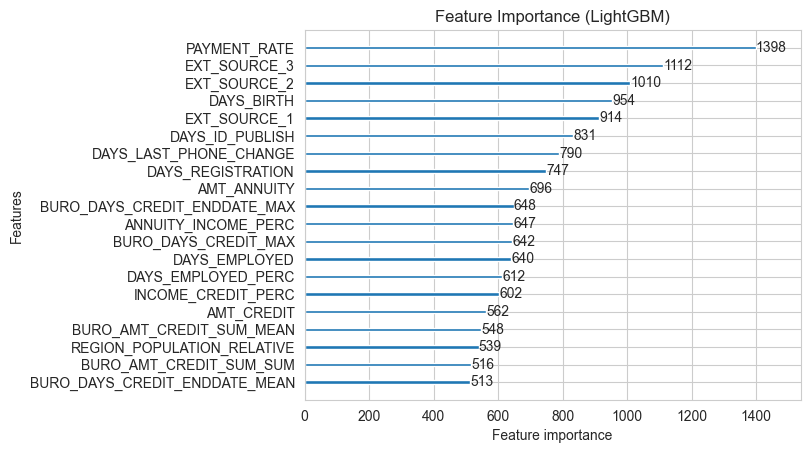

In [8]:
#Interprétabilité Globale (Feature Importance)


# Affichage des 20 variables les plus importantes pour le LightGBM
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgbm_model, max_num_features=20, importance_type='split')
plt.title("Feature Importance (LightGBM)")
plt.show()

Calcul des valeurs SHAP...


c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Format détecté : Tableau Unique

--- Feature Importance Locale (Summary Plot) ---


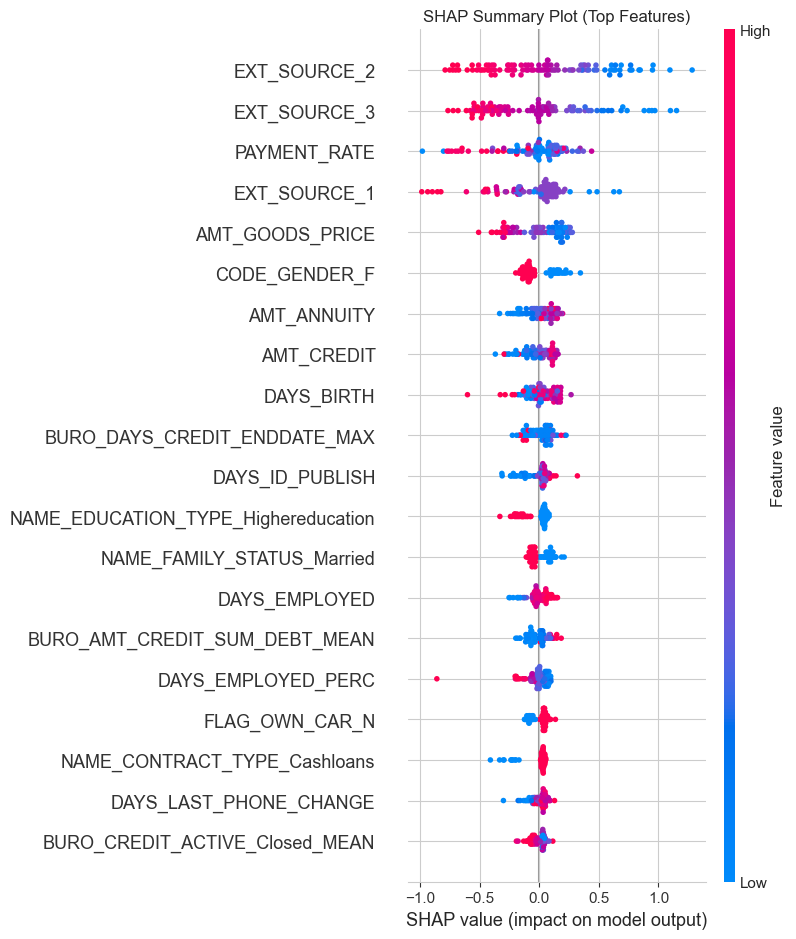

--- Explication pour le client index 180595 ---


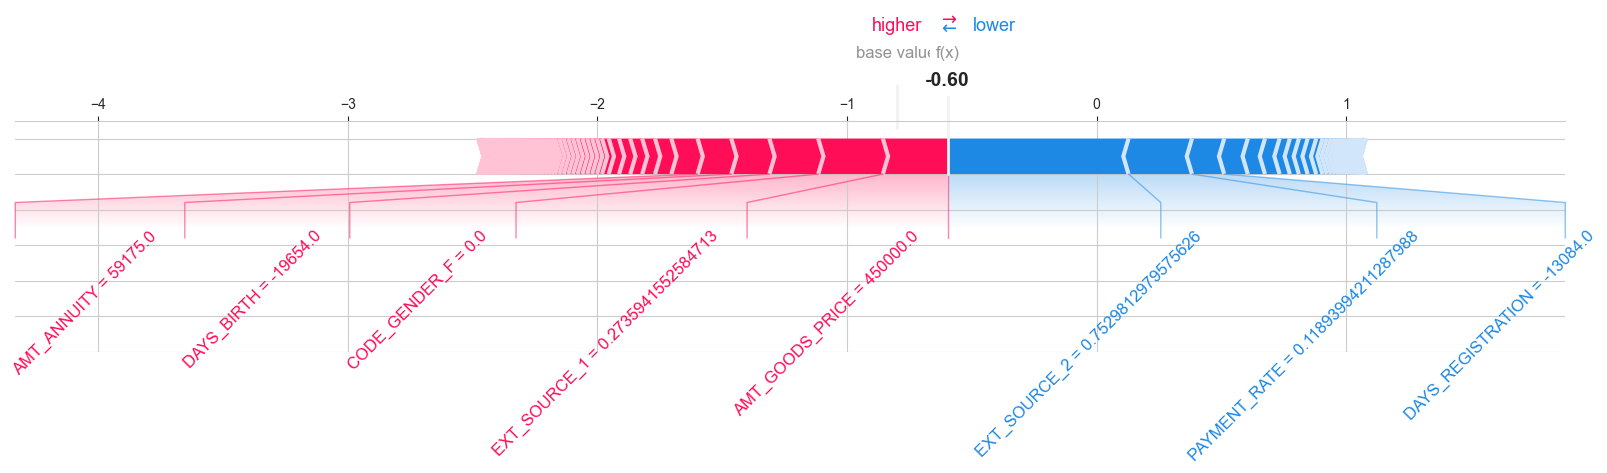

In [19]:
#Interprétabilité Locale (SHAP)


# --- Analyse SHAP ---
print("Calcul des valeurs SHAP...")

# On prend un échantillon de validation pour ne pas surcharger la mémoire
X_sample = X_val.iloc[:100]

# Création de l'explainer
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_sample)

# --- CORRECTION ROBUSTE ---
# SHAP peut renvoyer soit une liste [val_class0, val_class1], soit directement val_class1
# On détecte automatiquement le format pour éviter l'IndexError

if isinstance(shap_values, list):
    # Cas où SHAP renvoie une liste (Class 0, Class 1)
    print("Format détecté : Liste (Class 0, Class 1)")
    shap_val_target = shap_values[1] # On prend la classe 1 (Défaut)
    
    # Pareil pour expected_value
    if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
         expected_val_target = explainer.expected_value[1]
    else:
         expected_val_target = explainer.expected_value
else:
    # Cas où SHAP renvoie directement un tableau unique
    print("Format détecté : Tableau Unique")
    shap_val_target = shap_values
    expected_val_target = explainer.expected_value

# --- VISUALISATIONS ---

# 1. Summary Plot (Vue Globale)
print("\n--- Feature Importance Locale (Summary Plot) ---")
plt.title("SHAP Summary Plot (Top Features)")
shap.summary_plot(shap_val_target, X_sample)

# 2. Force Plot (Vue Individuelle pour le 1er client)
print(f"--- Explication pour le client index {X_sample.index[0]} ---")
# matplotlib=True est nécessaire pour afficher dans le notebook sans JS externe
shap.force_plot(
    expected_val_target, 
    shap_val_target[0,:], 
    X_sample.iloc[0,:], 
    matplotlib=True,
    text_rotation=45
)

In [10]:
#Sauvegarde 


# Sauvegarde du modèle final entraîné sur tout le dataset Train (Train + Val) pour la prod
final_model = LGBMClassifier(**lgbm_params)
final_model.fit(X, y)

# Sauvegarde pickle classique (pour l'API Flask plus tard)
import joblib
import os

if not os.path.exists('model_production'):
    os.makedirs('model_production')
    
joblib.dump(final_model, 'model_production/model.pkl')
print("Modèle sauvegardé dans 'model_production/model.pkl'")

# On sauvegarde aussi la liste des colonnes pour s'assurer que l'API attend les mêmes
feats_series = pd.Series(feats)
feats_series.to_csv('model_production/features.csv', index=False)
print("Liste des features sauvegardée.")

[LightGBM] [Info] Number of positive: 24825, number of negative: 282682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16537
[LightGBM] [Info] Number of data points in the train set: 307507, number of used features: 261
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Modèle sauvegardé dans 'model_production/model.pkl'
Liste des features sauvegardée.


In [11]:
import os

# On définit le chemin vers le dossier model_production à la racine
# '..' permet de remonter du dossier 'notebooks' vers la racine
output_dir = os.path.join('..', 'model_production')

# Sécurité : on crée le dossier s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Dossier créé : {output_dir}")

# Chemin complet du fichier
output_path = os.path.join(output_dir, 'test_sample_processed.csv')

print(f"Sauvegarde de l'échantillon vers : {output_path}")

# Sauvegarde
sample_test = test_df.head(1000)
sample_test.to_csv(output_path, index=False)

print(" Fichier généré avec succès ! Relance le Dashboard.")

Sauvegarde de l'échantillon vers : ..\model_production\test_sample_processed.csv
 Fichier généré avec succès ! Relance le Dashboard.


In [12]:
#Ajout d'un Modèle Linéaire (Régression Logistique)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print("--- Régression Logistique (Modèle Linéaire) ---")

# On crée un pipeline : Mise à l'échelle -> Modèle
# class_weight='balanced' gère le déséquilibre automatiquement
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))

with mlflow.start_run(run_name="Logistic_Regression"):
    # Entraînement
    lr_pipeline.fit(X_train, y_train)
    
    # Prédictions
    y_prob_lr = lr_pipeline.predict_proba(X_val)[:, 1]
    
    # Métriques
    auc_lr = roc_auc_score(y_val, y_prob_lr)
    best_thresh_lr, cost_lr = find_optimal_threshold(y_val, y_prob_lr)
    
    # Logging MLFlow
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("auc", auc_lr)
    mlflow.log_metric("business_cost", cost_lr)
    mlflow.log_metric("optimal_threshold", best_thresh_lr)
    
    # Sauvegarde
    mlflow.sklearn.log_model(lr_pipeline, "model")
    
    print(f"[LogReg] AUC: {auc_lr:.4f} | Coût Métier: {cost_lr} | Seuil Opt: {best_thresh_lr}")

--- Régression Logistique (Modèle Linéaire) ---


2026/01/12 17:09:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/12 17:09:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LogReg] AUC: 0.7515 | Coût Métier: 33035 | Seuil Opt: 0.5


In [13]:
#Optimisation du LightGBM avec GridSearchCV

print("\n--- Optimisation LightGBM (GridSearchCV) ---")

# 1. Définition de la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 500],        # Nombre d'arbres
    'learning_rate': [0.01, 0.05],     # Vitesse d'apprentissage
    'num_leaves': [30, 50],            # Complexité des arbres
    'class_weight': ['balanced']       # Toujours gérer le déséquilibre
}

# 2. Configuration du modèle de base
lgbm_base = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# 3. Lancement de la recherche (Optimisation sur l'AUC)
# On utilise AUC pour la recherche technique, puis on calculera le coût métier après
grid = GridSearchCV(lgbm_base, param_grid, cv=3, scoring='roc_auc', verbose=1)

with mlflow.start_run(run_name="LightGBM_GridSearch"):
    print("Démarrage du GridSearch...")
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    print(f"Meilleurs paramètres trouvés : {grid.best_params_}")
    
    # Évaluation du meilleur modèle sur le set de validation
    y_prob_best = best_model.predict_proba(X_val)[:, 1]
    
    auc_best = roc_auc_score(y_val, y_prob_best)
    best_thresh_best, cost_best = find_optimal_threshold(y_val, y_prob_best)
    
    # Logging MLFlow du CHAMPION
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("auc", auc_best)
    mlflow.log_metric("business_cost", cost_best)
    mlflow.log_metric("optimal_threshold", best_thresh_best)
    
    mlflow.sklearn.log_model(best_model, "model")
    
    print(f"[Best LightGBM] AUC: {auc_best:.4f} | Coût Métier: {cost_best} | Seuil Opt: {best_thresh_best}")
    
    # Alerte Overfitting (Critère demandé par Mickael)
    if auc_best > 0.82:
        print(" ATTENTION : AUC > 0.82. Risque de Data Leakage ou d'Overfitting !")


--- Optimisation LightGBM (GridSearchCV) ---
Démarrage du GridSearch...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Meilleurs paramètres trouvés : {'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 30}


2026/01/12 17:16:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/12 17:16:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[Best LightGBM] AUC: 0.7729 | Coût Métier: 31458 | Seuil Opt: 0.5


In [14]:
#Synthèse et Choix Final

# Comparaison rapide pour décider quel modèle sauvegarder pour l'API
print("\n--- Synthèse des performances ---")
print(f"1. Baseline Dummy   : Coût ~ {49650} (Référence)") # Valeur de ton run précédent
print(f"2. Régression Log.  : Coût = {cost_lr}")
print(f"3. LightGBM Optimisé: Coût = {cost_best}")

# Logique de sélection automatique
if cost_best < cost_lr:
    print("\n LE VAINQUEUR EST : LightGBM Optimisé")
    final_model_to_save = best_model
    final_threshold = best_thresh_best
else:
    print("\n LE VAINQUEUR EST : Régression Logistique (Surprenant !)")
    final_model_to_save = lr_pipeline
    final_threshold = best_thresh_lr

# Sauvegarde du VRAI modèle final pour l'API
import joblib
joblib.dump(final_model_to_save, 'model_production/model.pkl')
print(f"Modèle final sauvegardé dans 'model_production/model.pkl' avec le seuil recommandé de {final_threshold}")


--- Synthèse des performances ---
1. Baseline Dummy   : Coût ~ 49650 (Référence)
2. Régression Log.  : Coût = 33035
3. LightGBM Optimisé: Coût = 31458

 LE VAINQUEUR EST : LightGBM Optimisé
Modèle final sauvegardé dans 'model_production/model.pkl' avec le seuil recommandé de 0.5


Analyse de l'importance globale des variables...


<Figure size 1200x1000 with 0 Axes>

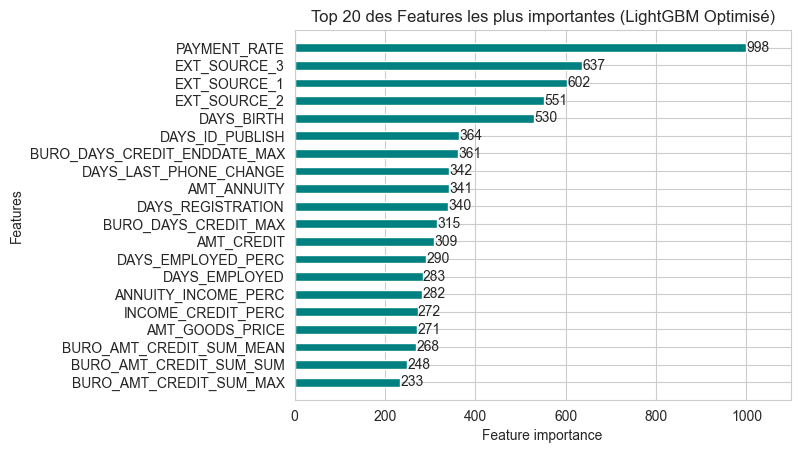

Top 10 Features :
     Value                       Feature
279    998                  PAYMENT_RATE
278    637                  EXT_SOURCE_3
277    602                  EXT_SOURCE_1
276    551                  EXT_SOURCE_2
275    530                    DAYS_BIRTH
274    364               DAYS_ID_PUBLISH
273    361  BURO_DAYS_CREDIT_ENDDATE_MAX
272    342        DAYS_LAST_PHONE_CHANGE
271    341                   AMT_ANNUITY
270    340             DAYS_REGISTRATION


In [15]:
# --- INTERPRÉTABILITÉ GLOBALE ---
import matplotlib.pyplot as plt
import lightgbm as lgb

print("Analyse de l'importance globale des variables...")

# On récupère le booster du meilleur modèle
booster = best_model.booster_

# Création du graphique
plt.figure(figsize=(12, 10))
lgb.plot_importance(booster, max_num_features=20, importance_type='split', height=0.5, color='teal')
plt.title("Top 20 des Features les plus importantes (LightGBM Optimisé)")
plt.show()

# Affichage textuel pour le rapport
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, X_train.columns)), columns=['Value','Feature'])
print("Top 10 Features :")
print(feature_imp.sort_values(by="Value", ascending=False).head(10))

Calcul des valeurs SHAP pour l'interprétabilité locale...


c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Format détecté : Tableau unique

--- SHAP Summary Plot ---


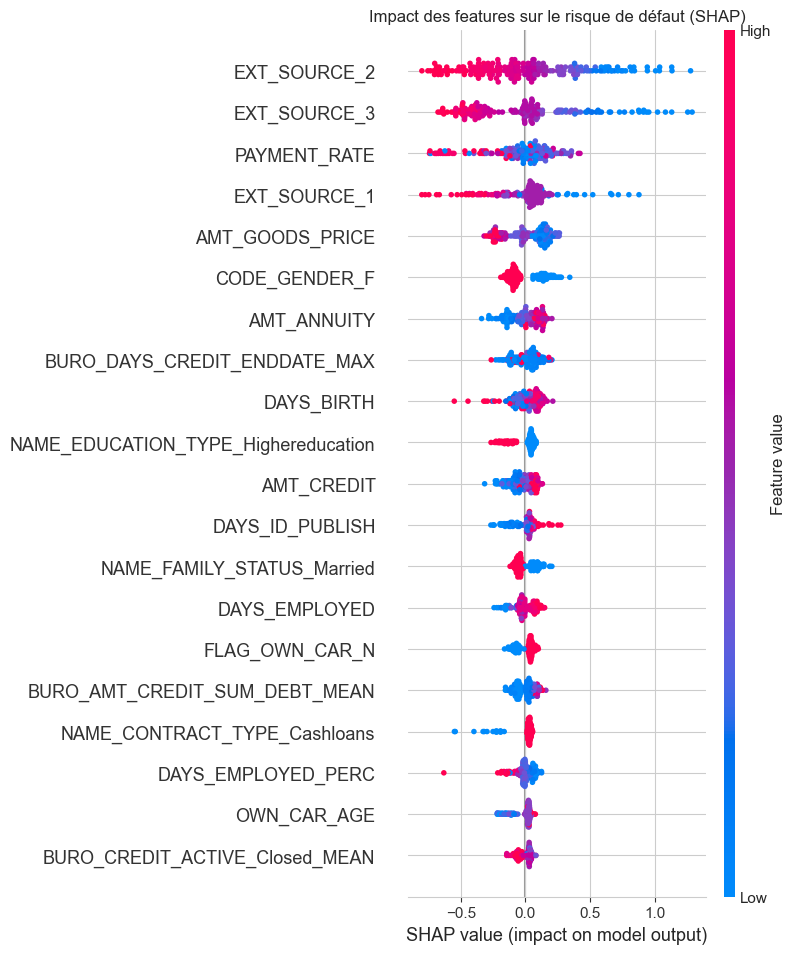


--- Explication Locale pour le client index 0 ---
Probabilité prédite : 43.80%


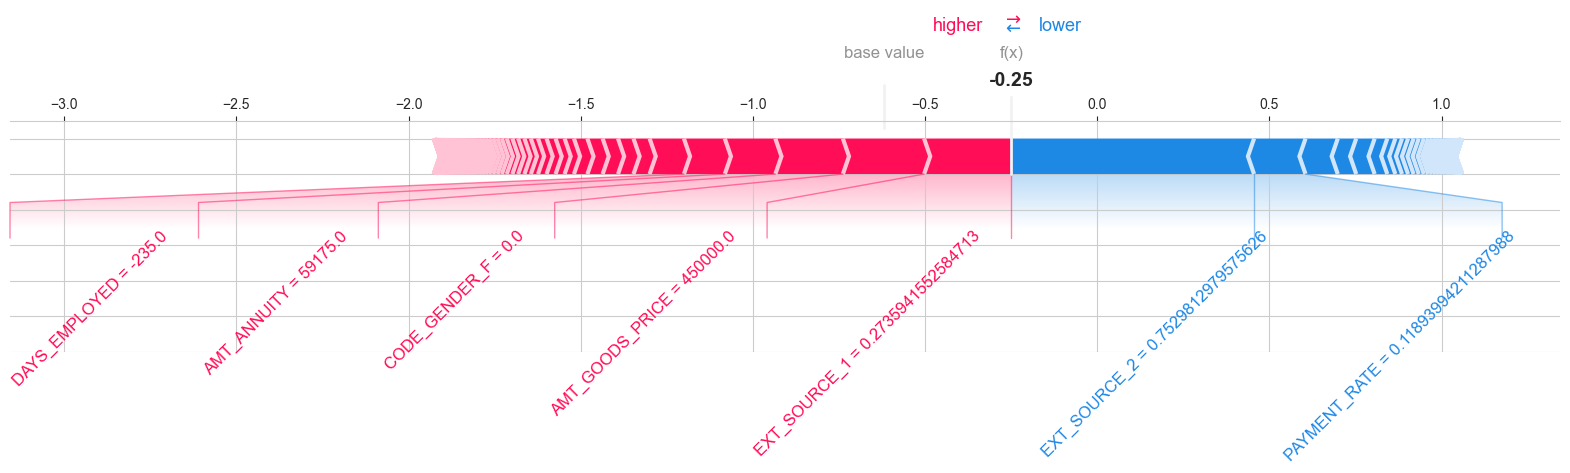

In [20]:
# --- INTERPRÉTABILITÉ LOCALE (SHAP) ---
import shap

print("Calcul des valeurs SHAP pour l'interprétabilité locale...")
# On utilise un échantillon du set de validation pour ne pas saturer la mémoire
X_shap_sample = X_val.iloc[:200]

# Initialisation de l'explainer SHAP avec le meilleur modèle
# model_output='probability' permet d'avoir des valeurs directement en probabilité (plus lisible)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_shap_sample)

# --- Gestion automatique du format de sortie SHAP ---
if isinstance(shap_values, list):
    print("Format détecté : Liste (Class 0, Class 1) -> Sélection de la classe 1 (Défaut)")
    shap_vals_target = shap_values[1]
    expected_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
else:
    print("Format détecté : Tableau unique")
    shap_vals_target = shap_values
    expected_val = explainer.expected_value

# 1. Summary Plot (Vue d'ensemble de l'impact des features)
print("\n--- SHAP Summary Plot ---")
plt.figure()
shap.summary_plot(shap_vals_target, X_shap_sample, show=False)
plt.title("Impact des features sur le risque de défaut (SHAP)")
plt.show()

# 2. Force Plot (Explication pour un client précis)
client_index = 0 # Premier client de l'échantillon
print(f"\n--- Explication Locale pour le client index {client_index} ---")
print(f"Probabilité prédite : {best_model.predict_proba(X_shap_sample.iloc[[client_index]])[:,1][0]:.2%}")

shap.force_plot(
    expected_val, 
    shap_vals_target[client_index,:], 
    X_shap_sample.iloc[client_index,:], 
    matplotlib=True,
    text_rotation=45,
    show=True
)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import mlflow
import joblib

print("--- Comparaison Multi-Modèles : ---")

# 1. CRÉATION D'UN ÉCHANTILLON (Indispensable pour RF et LGBM 1000)
# 50 000 lignes suffisent pour comparer la puissance des algos
sample_size = 50000
if len(X_train) > sample_size:
    print(f" Recherche des hyperparamètres sur {sample_size} lignes .")
    X_search, _, y_search, _ = train_test_split(
        X_train, y_train, train_size=sample_size, stratify=y_train, random_state=42
    )
else:
    X_search, y_search = X_train, y_train

# 2. DÉFINITION DES MODÈLES COMPLETS
models_to_test = [
    {
        "name": "Baseline_Dummy",
        "estimator": DummyClassifier(strategy='stratified', random_state=42),
        "param_grid": {}
    },
    {
        "name": "Logistic_Regression",
        "estimator": Pipeline([
            ('scaler', StandardScaler()), 
            ('clf', LogisticRegression(solver='saga', class_weight='balanced', max_iter=1000, random_state=42)) 
        ]),
        "param_grid": {
            'clf__C': [0.1, 1], # On garde 2 variantes
        }
    },
    {
        "name": "Random_Forest", # 
        "estimator": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
        "param_grid": {
            # On reste modeste sur le nombre d'arbres pour le RF car c'est très lent
            'n_estimators': [50, 100], 
            'max_depth': [10, 20]
        }
    },
    {
        "name": "LightGBM",
        "estimator": LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
        "param_grid": {
            'n_estimators': [500, 1000], 
            'learning_rate': [0.01, 0.05], # On teste lent et précis (0.01) vs rapide (0.05)
            'num_leaves': [30]
        }
    }
]

best_global_model = None
best_global_cost = float('inf')
best_global_name = ""
best_global_threshold = 0.5
results_summary = []

# 3. BOUCLE D'OPTIMISATION
for model_info in models_to_test:
    model_name = model_info["name"]
    print(f"\n🔹 Traitement du modèle : {model_name}...")
    
    grid = GridSearchCV(
        model_info["estimator"], 
        model_info["param_grid"], 
        cv=3, 
        scoring='roc_auc', 
        verbose=1
    )
    
    with mlflow.start_run(run_name=f"GridSearch_{model_name}"):
        # Entraînement sur l'échantillon
        grid.fit(X_search, y_search)
        best_est_search = grid.best_estimator_
        
        # Validation sur le VRAI set (X_val)
        y_prob = best_est_search.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_prob)
        opt_thresh, business_cost = find_optimal_threshold(y_val, y_prob)
        
        # Logging
        mlflow.log_params(grid.best_params_)
        mlflow.log_metric("auc", auc_score)
        mlflow.log_metric("business_cost", business_cost)
        
        print(f"    [Résultat {model_name}] AUC: {auc_score:.4f} | Coût: {business_cost}")
        print(f"    Params gagnants : {grid.best_params_}")
        
        results_summary.append({"Modèle": model_name, "AUC": auc_score, "Coût": business_cost})
        
        if business_cost < best_global_cost:
            best_global_cost = business_cost
            best_global_model = best_est_search 
            best_global_name = model_name
            best_global_threshold = opt_thresh

# 4. PHASE FINALE : RÉ-ENTRAÎNEMENT DU CHAMPION
print("\n" + "="*60)
print(f"LE GAGNANT EST : {best_global_name}")
print("Ré-entraînement du champion sur le Dataset COMPLET (300k lignes)...")

# On reprend la meilleure configuration trouvée 
final_model_full = best_global_model
final_model_full.fit(X_train, y_train)

print("Ré-entraînement terminé.")

# Sauvegarde
joblib.dump(final_model_full, 'model_production/model.pkl')
with open('model_production/threshold.txt', 'w') as f:
    f.write(str(best_global_threshold))

print(f"Modèle final ({best_global_name}) sauvegardé avec succès.")

--- Comparaison Multi-Modèles : ---
 Recherche des hyperparamètres sur 50000 lignes .

🔹 Traitement du modèle : Baseline_Dummy...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
    [Résultat Baseline_Dummy] AUC: 0.5033 | Coût: 49865
    Params gagnants : {}

🔹 Traitement du modèle : Logistic_Regression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached w

    [Résultat Logistic_Regression] AUC: 0.7453 | Coût: 33413
    Params gagnants : {'clf__C': 0.1}

🔹 Traitement du modèle : Random_Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
    [Résultat Random_Forest] AUC: 0.7231 | Coût: 35621
    Params gagnants : {'max_depth': 10, 'n_estimators': 100}

🔹 Traitement du modèle : LightGBM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
    [Résultat LightGBM] AUC: 0.7554 | Coût: 32593
    Params gagnants : {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 30}

LE GAGNANT EST : LightGBM
Ré-entraînement du champion sur le Dataset COMPLET (300k lignes)...
Ré-entraînement terminé.
Modèle final (LightGBM) sauvegardé avec succès.


In [25]:
from lightgbm import LGBMClassifier
import joblib

print("FORÇAGE : Entraînement final manuel (LightGBM 1000 arbres)...")

# 1. Configuration "Champion" (Optimisée pour le dataset complet)
# On force 1000 arbres avec un learning_rate bas (0.01) pour une précision maximale car de meilleurs performances dans cellule précédente
params_final = {
    'n_estimators': 1000,        
    'learning_rate': 0.01,       
    'num_leaves': 30,
    'class_weight': 'balanced',  # Crucial pour le scoring
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

# 2. Création et Entraînement sur TOUT le dataset (X_train)
final_model_forced = LGBMClassifier(**params_final)
final_model_forced.fit(X_train, y_train)

# 3. Sauvegarde
# On écrase le modèle précédent pour être sûr que l'API utilise celui-ci
joblib.dump(final_model_forced, 'model_production/model.pkl')

# On sauvegarde aussi le seuil standard (0.5 est optimal avec class_weight='balanced')
with open('model_production/threshold.txt', 'w') as f:
    f.write("0.5")

print("Modèle LightGBM (1000 arbres) sauvegardé dans 'model_production/model.pkl'.")


FORÇAGE : Entraînement final manuel (LightGBM 1000 arbres)...
Modèle LightGBM (1000 arbres) sauvegardé dans 'model_production/model.pkl'.


---  Évaluation Finale du Modèle champion réentrainé : LGBMClassifier ---
 AUC Final : 0.7719
 Seuil Optimal retenu : 0.5
 Coût Métier sur Validation : 31507

--- Rapport de Classification ---
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     56537
         1.0       0.18      0.69      0.28      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.70      0.55     61502
weighted avg       0.90      0.72      0.78     61502



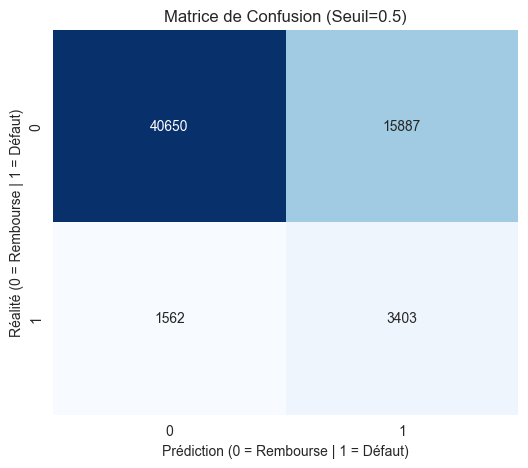

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# ON POINTE VERS LE MODÈLE FORCÉ
model_to_test = final_model_forced 

print(f"---  Évaluation Finale du Modèle champion réentrainé : {model_to_test.__class__.__name__} ---")

# 1. Prédictions sur le jeu de validation
# (Rappel : X_val n'a pas servi à l'entraînement, c'est un test honnête)
y_prob_final = model_to_test.predict_proba(X_val)[:, 1]

# 2. Recalcul des scores
auc_final = roc_auc_score(y_val, y_prob_final)
thresh_final, cost_final = find_optimal_threshold(y_val, y_prob_final)

print(f" AUC Final : {auc_final:.4f}")
print(f" Seuil Optimal retenu : {thresh_final}")
print(f" Coût Métier sur Validation : {cost_final}")

# 3. Création des prédictions binaires (0 ou 1) selon le seuil optimal
y_pred_final = (y_prob_final >= thresh_final).astype(int)

# 4. Affichage Rapport & Matrice
print("\n--- Rapport de Classification ---")
print(classification_report(y_val, y_pred_final))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_val, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Matrice de Confusion (Seuil={thresh_final})")
plt.xlabel("Prédiction (0 = Rembourse | 1 = Défaut)")
plt.ylabel("Réalité (0 = Rembourse | 1 = Défaut)")
plt.show()

Analyse d'interprétabilité pour le modèle : LGBMClassifier
Calcul des valeurs SHAP...


c:\Users\wahid.ameur\AppData\Local\anaconda3\envs\PROJET6\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Format détecté : Tableau unique.

--- Impact Global des Features (Summary Plot) ---


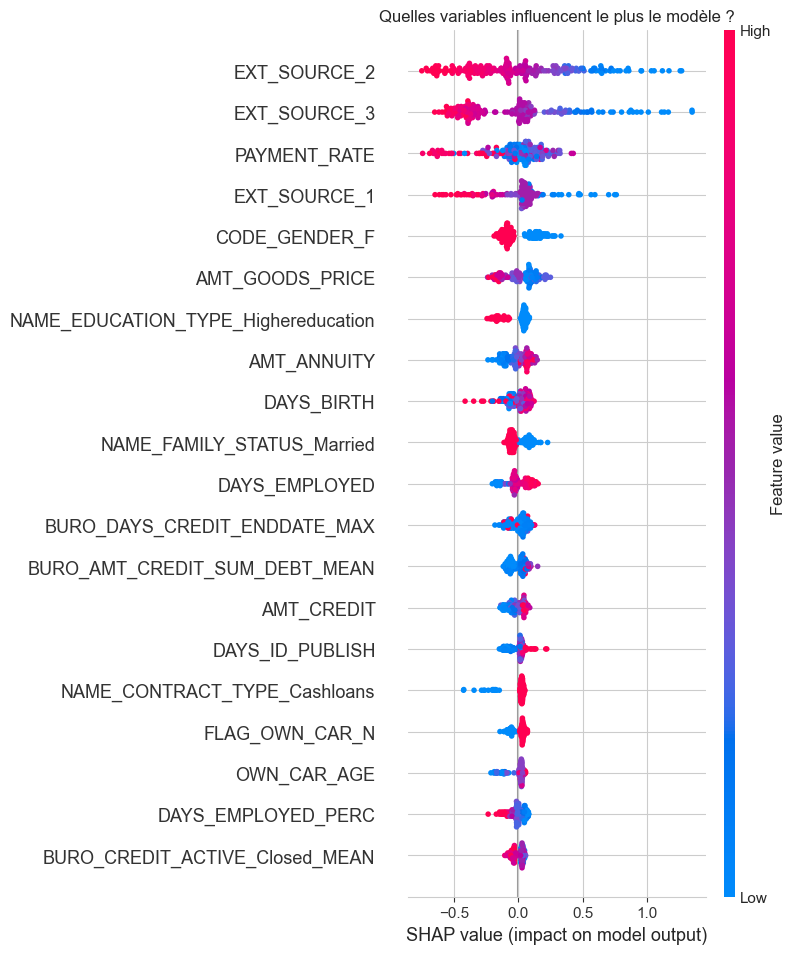


--- Explication Locale (Force Plot) - Client Index 0 ---


<Figure size 2000x400 with 0 Axes>

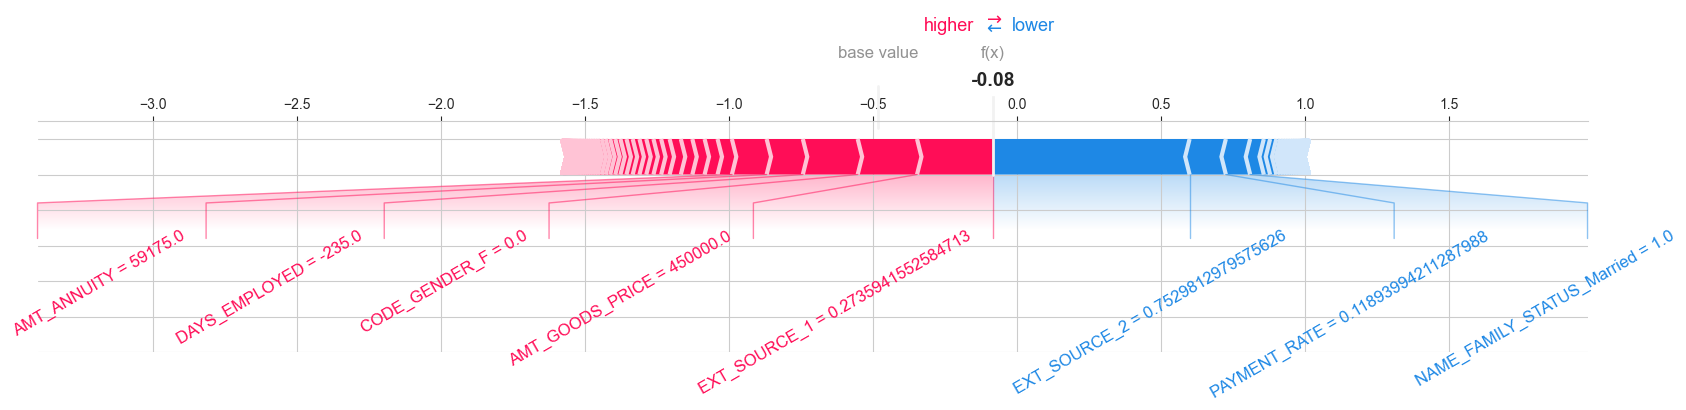


--- Explication Locale (Waterfall Plot) - Client Index 0 ---


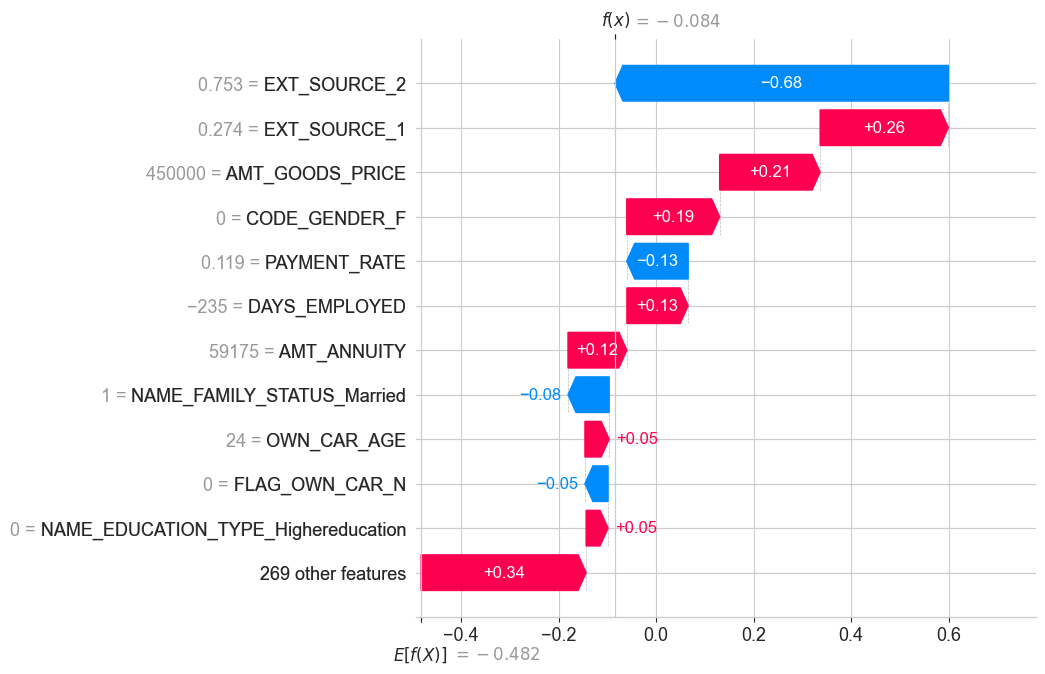

In [29]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# --- CONFIGURATION ---
# ON POINTE VERS LE MODÈLE réentrainé
target_model = final_model_forced

print(f"Analyse d'interprétabilité pour le modèle : {target_model.__class__.__name__}")

# On prend un échantillon du set de validation (ex: 200 clients) pour la rapidité
X_shap_sample = X_val.iloc[:200]

# --- 1. CALCUL DES VALEURS SHAP ---
print("Calcul des valeurs SHAP...")
explainer = shap.TreeExplainer(target_model)
shap_values = explainer.shap_values(X_shap_sample)

# Gestion des formats de sortie (Liste vs Tableau)
if isinstance(shap_values, list):
    print("Format détecté : Liste (probablement binaire). Sélection de la classe 1 (Défaut).")
    shap_vals_target = shap_values[1]
    # Récupération de l'espérance (moyenne)
    if isinstance(explainer.expected_value, list):
        expected_val = explainer.expected_value[1]
    else:
        expected_val = explainer.expected_value
else:
    print("Format détecté : Tableau unique.")
    shap_vals_target = shap_values
    expected_val = explainer.expected_value

# --- 2. SUMMARY PLOT (Vue Globale) ---
print("\n--- Impact Global des Features (Summary Plot) ---")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_vals_target, X_shap_sample, show=False)
plt.title("Quelles variables influencent le plus le modèle ?")
plt.show()

# --- 3. FORCE PLOT (Vue Locale - Client 0) ---
print("\n--- Explication Locale (Force Plot) - Client Index 0 ---")
client_idx = 0

plt.figure(figsize=(20, 4)) # Largeur de 20 pouces pour étaler le texte
shap.force_plot(
    expected_val, 
    shap_vals_target[client_idx,:], 
    X_shap_sample.iloc[client_idx,:], 
    matplotlib=True,
    text_rotation=30, # Rotation pour éviter les collisions
    show=True
)

# --- 4. WATERFALL PLOT (Vue Locale Alternative) ---
print("\n--- Explication Locale (Waterfall Plot) - Client Index 0 ---")
# Création d'un objet Explanation pour le nouveau format de plot
shap_exp = shap.Explanation(
    values=shap_vals_target[client_idx], 
    base_values=expected_val, 
    data=X_shap_sample.iloc[client_idx], 
    feature_names=X_shap_sample.columns
)

plt.figure()
shap.plots.waterfall(shap_exp, max_display=12, show=True)